<a href="https://colab.research.google.com/github/rehanvipin/hello-world/blob/master/speedy_draw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quick draw but without considering strokes, because CNNs.
---------------------------------------------------------  
//Wont work in real time then, can only guess after the final image has been drawn. 
Go! Go! Go!

# Steps to follow

1.   Get the data, understand it
2.   Build a data pipelines, GPUs should not starve
3.   Build the model, a CNN
4.   Train the model
5.   Test the model on new data
6.   Make changes, repeat

## Currently working on:
Stage 1 done!  
Stage 2 done!  
Static human input works!  
Live input


## 1. Fetch the data from google cloud, unpack it
> List alternative, better sources if you find them  
> Also, you can skip this section(1) without affecting the runtime of the later sections.  
> It's just there for initial exploration, skip while developing

In [0]:
!gsutil -m cp gs://quickdraw_dataset/full/numpy_bitmap/apple.npy .
!ls

Copying gs://quickdraw_dataset/full/numpy_bitmap/apple.npy...
\ [1/1 files][108.2 MiB/108.2 MiB] 100% Done                                    
Operation completed over 1 objects/108.2 MiB.                                    
apple.npy  full_dataset.npz  sample_data  whatsthis.png


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
apple_data = np.load('apple.npy')

In [0]:
apple_data.shape

(144722, 784)

In [0]:
def plot_images(arr_images, n):
  fig, axes = plt.subplots(1, n, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(arr_images, axes):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(4, 784)
(4, 28, 28)


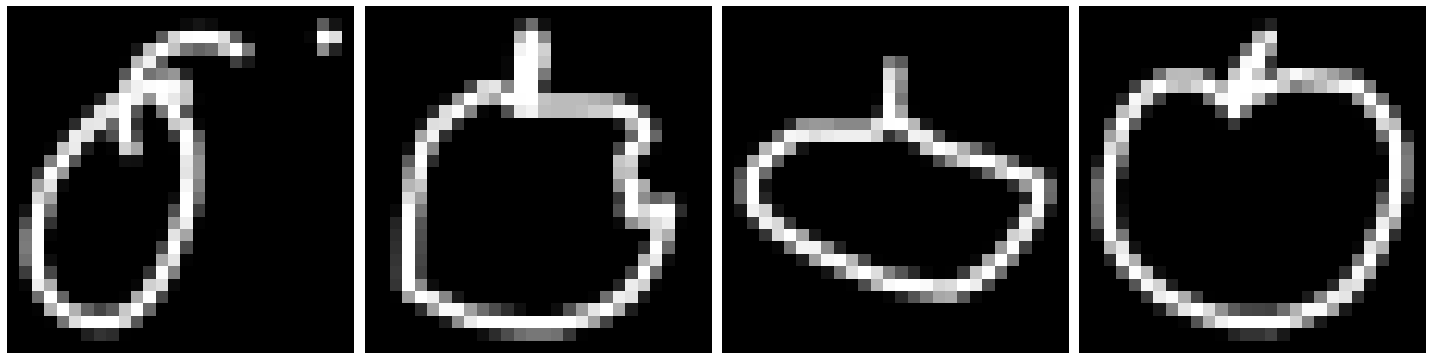

In [0]:
sample_apples = apple_data[:4]
new_apples = []
print(sample_apples.shape)
for i in range(4):
  sample_apple = sample_apples[i].reshape(28, 28)
  new_apples.append(sample_apple)
new_apples = np.array(new_apples)
print(new_apples.shape)
plot_images(new_apples, 4)

All that fancy stuff above is good for colab, but to make an actual dataset, we're gonna have to compile it on our computers and then upload it online somewhere.

## No of classes: ```20```
## No of images per class: ```4000```
That's my opinion on the dataset I think we should have, feel free to change it.  
Use [this](https://quickdraw.withgoogle.com/data) as reference for making your choices.
### The classes: (Make them as different as possible)
> axe, bat, bird, bridge, ceiling fan, crab, drill, fire hydrant, grapes, hourglass, lightning, motorbike,
> paintbrush, scissors, stereo, tent, umbrella, windmill, rainbow

Stages:  
1. 7 classes, 1000 images each, with a validation split of 0.2
2. 20 classes, 4000 images each, tbd

Get the .npy files from:
[here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified)

## 2. Building the data pipeline

Stage 2 done, looking at actual usage now

The reduced dataset in kept in a separate directory, here is the format of the directory
```
.
├── dataset              # original dataset from google
├── production_dataset   # smaller, final dataset
├── small_dataset        # smaller, initial dataset
├── stage2.py            # utility scripts
├── step1.py
└── step2.py
```

### Next steps:


*   Read images from the disk
*   Decode them correctly
*   Convert them into tensors and normalize them
*   Shuffle the pipleline and batch them



Made the directories with the datasets. Now, the images have to be reshaped into 2D images, bringing back information about their spatial locality so they can be processed by the CNN. 

In [0]:
# Use this if you can't drag and drop
from google.colab import files
uploaded = files.upload()
# Upload the dataset npz file when prompted
for name, data in uploaded.items():
  with open(name, 'wb') as wire:
    wire.write(data)
!ls

Saving full_dataset.npz to full_dataset.npz
full_dataset.npz  sample_data


In [0]:
# stage 1 stuff, don't execute this if you want to test stage2

og_dataset = np.load("full_dataset.npz")
features = og_dataset["features"]
labels = og_dataset["labels"]
mapping = {0: 'axe', 1: 'bat', 2: 'bear', 3: 'bird', 4: 'bridge', 5: 'ceiling_fan', 6: 'crab'}
NO_OF_CLASSES = len(mapping)
features = features.reshape((features.shape[0], 28, 28, 1))
features = features/255
features.shape

In [0]:
# Stage 2 stuff, execute this, pretty please?
import numpy as np
mapping = {0: 'axe', 1: 'bat', 2: 'bear', 3: 'bird', 4: 'bridge', 5: 'ceiling_fan', 6: 'crab', 7: 'drill', 8: 'fire hydrant', 9: 'grapes', 10: 'hourglass', 11: 'lightning', 12: 'motorbike', 13: 'paintbrush', 14: 'rainbow', 15: 'scissors', 16: 'stereo', 17: 'tent', 18: 'umbrella', 19: 'windmill'}
NO_OF_CLASSES = len(mapping)
og_dataset = np.load("full_dataset.npz")
features = og_dataset["features"]
labels = og_dataset["labels"]
features = features.reshape((features.shape[0], 28, 28, 1))
features = features/255
features.shape

In [0]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)  # one hot encoding !!! 🔥

The data and the labels are ready, convert them into tensors to build a data pipeline.  
Maybe it's time to add more data and classes?

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD    # Never used, kept as a tribute

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
# Shuffle the dataset for uniformity and learning, and split them into batches to train faster
BATCH_SIZE = 64
BUFFER_SIZE = features.shape[0] # That's because there is zero shuffling initially
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# One look at the dataset before we make the model
road = dataset.as_numpy_iterator()
x = next(road)
f, l = x
print(f.shape)
l = np.argmax(l)
plt.imshow(f[0].reshape(28,28))
print(mapping[l])
# print(f)

## There, the data pipeline is ready to be fed to the model.
Let's design the model.  
T̶w̶o̶ ̶l̶a̶y̶e̶r̶s̶ ̶o̶f̶ ̶c̶o̶n̶v̶o̶l̶u̶t̶i̶o̶n̶ ̶a̶n̶d̶ ̶p̶o̶o̶l̶i̶n̶g̶,̶ ̶f̶o̶l̶l̶o̶w̶e̶d̶ ̶b̶y̶ ̶t̶w̶o̶ ̶d̶e̶n̶s̶e̶ ̶l̶a̶y̶e̶r̶s̶.̶ ̶A̶t̶ ̶t̶h̶e̶ ̶o̶u̶p̶u̶t̶ ̶l̶a̶y̶e̶r̶ ̶w̶e̶ ̶k̶e̶e̶p̶ ̶7̶ ̶n̶e̶u̶r̶o̶n̶s̶,̶ ̶r̶e̶p̶r̶e̶s̶e̶n̶t̶i̶n̶g̶ ̶t̶h̶e̶ ̶p̶r̶o̶b̶a̶b̶i̶l̶i̶t̶y̶ ̶f̶o̶r̶ ̶e̶a̶c̶h̶ ̶o̶f̶ ̶t̶h̶e̶ ̶s̶e̶v̶e̶n̶ ̶c̶l̶a̶s̶s̶e̶s̶.̶   
We aren't classifying classical paintings, we don't that here.  
**One** layer of convolution and pooling, followed by one hidden dense layer and one output dense layer.


## 3. Building the model

In [0]:
# The model we've been waiting for, let the dark magic commence
model = Sequential([
                    Conv2D(16, 3, input_shape=(28,28,1)),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(512, activation="relu"),
                    Dense(20, activation="softmax")
])
model.build()
model.summary()

In [0]:
# Let's visualize!
tf.keras.utils.plot_model(model, to_file="kendall_jenner.png",
                          show_shapes=True)

In [0]:
opt = SGD(learning_rate = 1e-2)
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

## 4. Training the model

But wait, we don't want to train on just everything, let's keep some data aside for testing, so that we can see how much we have generalized and if we need dropouts.

In [0]:
no_of_batches = len(list(dataset))
print(no_of_batches)
test_split = int(0.2 * no_of_batches)
test_dataset = dataset.take(test_split)
train_dataset = dataset.skip(test_split)

1250


In [0]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs=8)

Epoch 1/8
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0780 - accuracy: 0.9780 - val_loss: 0.0582 - val_accuracy: 0.9837
Epoch 2/8
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0600 - accuracy: 0.9830 - val_loss: 0.0408 - val_accuracy: 0.9889
Epoch 3/8
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0546 - accuracy: 0.9831 - val_loss: 0.0430 - val_accuracy: 0.9883
Epoch 4/8
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0339 - val_accuracy: 0.9902
Epoch 5/8
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0334 - val_accuracy: 0.9892
Epoch 6/8
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0383 - accuracy: 0.9881 - val_loss: 0.0390 - val_accuracy: 0.9878
Epoch 7/8
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0398 - accuracy: 0.9873 - val_loss: 0.0313 - val_accuracy: 0.9903

## Here's a lesson in trickery!  
Load the model with the weights here, skip all the steps before this.  
Parkour!

In [0]:
model = tf.keras.models.load_model("the_maze.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1384960   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 1,395,380
Trainable params: 1,395,380
Non-trainable params: 0
_________________________________________________________________


## 5. Testing the model

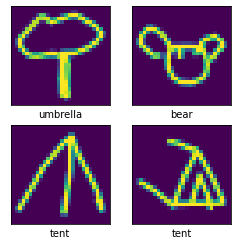

In [0]:
from random import randint
preds = [randint(0, 80000) for _ in range(4)]
pred_input = np.array([features[inx] for inx in preds])
pred_output = model.predict(pred_input)
plt.figure(figsize=(4,4))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(features[preds[i]].reshape(28, 28))
  plt.xlabel(mapping[np.argmax(pred_output[i])])
plt.show()

Yay! That's very nice, but how well do we perform on data that has not been seen yet? Let keras tell us how good we are.

In [0]:
final_loss, final_accuracy = model.evaluate(test_dataset)
print(f"This model has an accuracy: {round(final_accuracy, 3)} with a loss {round(final_loss, 2)}")

250/250 [==============================] - 1s 4ms/step - loss: 0.0231 - accuracy: 0.9927
This model has an accuracy: 0.993 with a loss 0.02


How much trouble did the poor thing go through before it reached this far? Let's plot because why not?

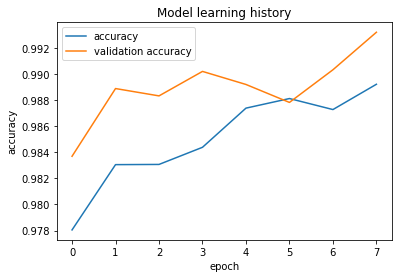

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model learning history")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["accuracy", "validation accuracy"], loc="upper left")
plt.show()

This has been a lot of work, let the model rest the next time, save the weights for future use.

In [0]:
model.save("the_maze.h5")

##     Fix bugs, repeat

## 6. Production code

Only working code and functions here, draw stuff and let the model guess what it is.   
Input must be in the same format as the training data

Get images from disk (or another source later) and resize them to 28 x 28 for the functions after this

In [0]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def resize_28(image_name):
  """
  return an image of size 28 x 28 from the file name
  """
  image = Image.open(image_name)
  image = image.convert("L")
  image = ImageOps.invert(image)
  image = image.resize((28, 28))
  image = np.asarray(image)
  return image

resize_28 gets the image from the disk and nicely formats it into the exact format the model accepts, thank you.

In [0]:
mapping = {0: 'axe', 1: 'bat', 2: 'bear', 3: 'bird', 4: 'bridge', 5: 'ceiling_fan', 6: 'crab', 7: 'drill', 8: 'fire hydrant', 9: 'grapes', 10: 'hourglass', 11: 'lightning', 12: 'motorbike', 13: 'paintbrush', 14: 'rainbow', 15: 'scissors', 16: 'stereo', 17: 'tent', 18: 'umbrella', 19: 'windmill'}
def predict_label(image_name):
  bluecat = resize_28(image_name)/255
  plt.figure()
  plt.imshow(bluecat)
  plt.grid(False)
  bluecat = bluecat.reshape((28, 28, 1))
  sees = model.predict(np.array([bluecat]))
  best = np.argmax(sees)
  plt.xlabel(mapping[best])
  plt.show()

A wrapper function that takes a filename, gets the file from the disk and makes predictions from the model, but plots the image and prediction instead, needs the mapping dictionary for that.

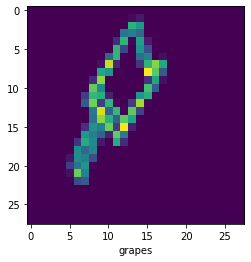

In [0]:
predict_label("whatsthis.png")

FIN.

